## SAM model
You will start from offical SAM implementation, the heavy part is already implementated, but you have to make modification to the model, it's critical to read their code and know how things work. You will need to read through SAM's code starting from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/image_encoder.py

For SAM: See Appendix A https://arxiv.org/pdf/2304.02643.pdf

In [24]:
input_point = np.array([[20,20], [20,50]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [25]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])


In [27]:
input_box = np.array([60, 70, 110, 90])

In [28]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])


## LoRA module
We also provide you an toy example of LoRA module injected into any nn.Linear class. You will implement similar LoRA class for Conv2D and ConvTranspose2d.

For LoRA: https://arxiv.org/abs/2106.09685

## Methods and Results (in your report)

1. how do you implement LoRA, which part of SAM model do you fine-tune?
2. summarize number of parameters before and after LoRA
3. compare training results of completely unfreeze SAM v.s. LoRA.

## SAM target assignment

Take a closer look at the data, there's some big mask containing small masks. the SAM model will predict 3 output masks (with 3 confidence score) for a single prompt, 3 mask outputs is ordered from big to small objects. You will need to implement function to sample these 3 masks from masks of one image in SA-1B dataset.

In [25]:
def point_sample(all_masks, points_coords, points_label):
    # all_masks: [N, H, W], one image, N masks
    # points_coords: (N, 2)
    # points_label: (N, 1), 1 for foreground, 0 for background
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function

    mask_ids = []
    for i, mask in enumerate(all_masks):
        is_valid = True
        for is_fore, (x, y) in zip(points_label, points_coords):
            on_mask = mask[y][x]
            is_valid = (on_mask and is_fore) or (not on_mask and not is_fore)
            if not is_valid:
                break

        if is_valid:
            mask_ids.append(i)

    #if len(mask_ids) == 
    mask_ids.sort(key=lambda i: all_masks[i].sum())
    return all_masks[mask_ids[:3]]



def box_sample(all_masks, bbox):
    # all_masks: [N, H, W], one image, N masks
    # bbox: (xxyy)
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

# you don't need to implement the case with both points and box

torch.Size([45, 160, 256])


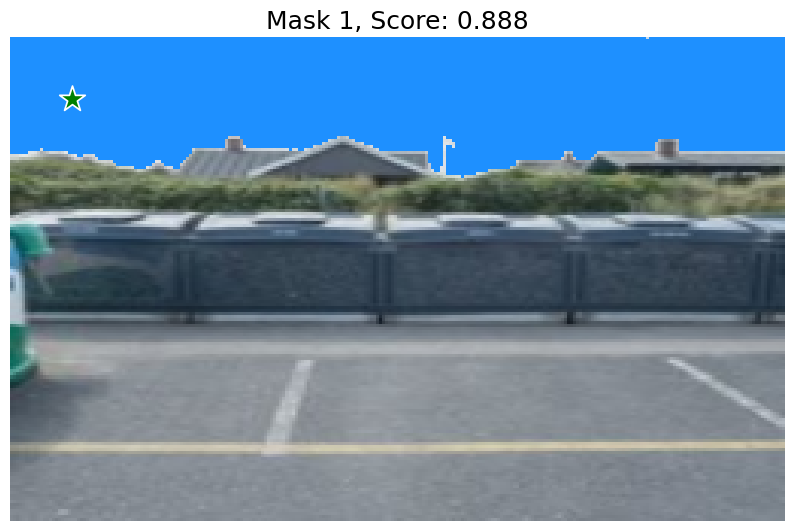

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 1])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

print(target.shape)
input_point = np.array([(20, 20)])
masks = point_sample(target, input_point, np.array([(1)]))

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## Visulize (in your report)

show the returned 3 masks, ordered from big to small

show `point_sample()` with 1. one positive point, 2. one positive and one negative point. 3. multiple points with both positive and negative

show `box_sample()` with 1. one positive box

## Training
as described in SAM paper Section 3 and Appendix A. You simulate an interactive segmentation setup during training: you need to implement 1a. single point prompt training 1b. iterative training up to 3 iteration 2. box prompt training, only 1 iteration;

### 1a and 2: one iteration training
First, with equal probability either a foreground point
or bounding box is selected randomly for the target mask.
Points are sampled uniformly from the ground truth mask.
Boxes are taken as the ground truth mask’s bounding box,
with random noise added in each coordinate with standard
deviation equal to 10% of the box sidelength, to a maximum of 20 pixels.

### 1b: three iteration training
After making a prediction from this first prompt, subsequent points are selected uniformly from the error region
between the previous mask prediction and the ground truth
mask. Each new point is foreground or background if the error region is a false negative or false positive, respectively.
We also supply the mask prediction from the previous iteration as an additional prompt to our model. To provide
the next iteration with maximal information, we supply the
unthresholded mask logits instead of the binarized mask.
When multiple masks are returned, the mask passed to the
next iteration and used to sample the next point is the one
with the highest predicted IoU.

- You do not need to implement text prompt as there's no text data in SA-1B dataset

In [1]:
import lora_sam
import pytorch_lightning as pl

model = lora_sam.LoRASAM(4, 1)
train_loader, val_loader = lora_sam.get_loaders(batch_size=1)
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=30)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bardiche4768/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.

Sanity Checking: 0it [00:00, ?it/s]

/home/bardiche4768/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/bardiche4768/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 63.52it/s]

/home/bardiche4768/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('val_loss', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
/home/bardiche4768/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antial

/home/bardiche4768/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/8948 [00:00<?, ?it/s] 

/home/bardiche4768/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/bardiche4768/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in or

torch.Size([1, 3, 160, 256]) torch.Size([1, 82, 160, 256])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 1024, 1024]

## Results (in your report)

1. show the process of sampling points in multiple iteration training, how the GT mask is assigned in each iteration
1. show training / validation loss curve, for each loss and sum of all losses.
1. besides loss, think about metrics such as mIoU, mAP, how to implement them in the sam's setting, or why not to implement each metrics, what make them unsuitable for sam's task? Remember: 1) we only have masks without category 2) sam need prompts.
1. on your trained model, cherry pick good examples, but also pick bad examples, rescale the input image back to 1024x1024 pixels, pass them to the original SAM model with the original pipeline, compare to your low-resolution LoRA results, disccuss what make them good or bad.